# Simulation: outage probability versus radius

## Loading libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from statsmodels.stats.proportion import proportion_confint

from misc import line_equation_coefficients
from misc import dist_to_obstructions
from misc import blocked_rays_main_paths
from misc import fcombine

## Room parameters

In [2]:
# Room dimensions
Lx = 30
Ly = 20
room_area = Lx * Ly

# Transmitter and receiver cooordinates
x_Tx = 8
y_Tx = 3

x_Rx = 15
y_Rx = 10

# RIS center coordinates
ris_center_x = 12
ris_center_y = 0
N = 64

## Simulation Parameters

In [3]:
trials = 100000

GHz  = 18             # operating frequency
c    = 299792458      # speed of light
lmbd = 0.5            # intensity of the PPP (m^(-2))
sgm2 = 1.658e-11      # Noise varianve
Pt   = 0.1            # Transmitted power

# Antenna gain
GtdB = 20             # Transmitter antenna gain in dB   
GrdB = 10             # Recaiver antenna gain in dB
Gt   = np.power(10, GtdB/10)
Gr   = np.power(10, GrdB/10)
G    = Gr * Gt
B    = sgm2/(Pt * G)

# Table 2 (paper)
if (GHz == 18):
    z  = 130
    AO = 0.00006
    f  = 18e9
if (GHz == 26):
    z  = 200
    AO = 0.00013
    f  = 26e9
if (GHz == 60):
    z  = 390
    AO = 0.015
    f  = 60e9
if (GHz == 73):
    z  = 420
    AO = 0.0075
    f  = 73e9
    
wvlen= c / f          # Signal wavelength
dx = wvlen/2          # RIS cell side size

## RIS cell coordinates

In [4]:
# RIS on the bottom wall
if (ris_center_y == 0):
    x_RIS  = dx * (np.linspace(1-N/2,N/2,N) - 0.50) + ris_center_x
    y_RIS  = np.zeros(N) 
    wall = 'bottom'
# RIS on the left wall
if (ris_center_x == 0):
    y_RIS  = dx * (np.linspace(1-N/2,N/2,N) - 0.50) + ris_center_y
    x_RIS  = np.zeros(N)
    wall = 'left'
# RIS on the upper wall
if (ris_center_y == Ly):
    x_RIS  = dx * (np.linspace(1-N/2,N/2,N) - 0.50) + ris_center_x    # RIS x-coordinates
    y_RIS  = np.ones(N) * Ly
    wall = 'upper'
# RIS on the right wall
if (ris_center_x == Lx):
    y_RIS  = dx * (np.linspace(1-N/2,N/2,N) - 0.50) + ris_center_y     # RIS x-coordinates
    x_RIS  = np.ones(N) * Lx
    wall = 'right'

## Free space path loss

In [5]:
# LOS path
TxRx = line_equation_coefficients(x_Tx, x_Rx, y_Tx, y_Rx, 'single')
# Tx-RIS paths
TxRIS = line_equation_coefficients(x_Tx, x_RIS, y_Tx, y_RIS, 'multiple')
# RIS-Rx paths
RISRx = line_equation_coefficients(x_RIS, x_Rx, y_RIS, y_Rx, 'multiple')
# Tx-RIScenter 
TxRISc = line_equation_coefficients(x_Tx, ris_center_x, y_Tx, ris_center_y, 'single')
# Tx-RIScenter 
RIScRx = line_equation_coefficients(ris_center_x, x_Rx, ris_center_y, y_Rx, 'single')

# Distances
dk0     = np.sqrt(np.power(x_Rx - x_Tx, 2) + np.power(y_Rx - y_Tx, 2))
dRIS    = TxRIS.d + RISRx.d

# Free space path loss for LOS path and reflection paths
Lk      = 20 * np.log10(4 * np.pi * f * dk0 / c) + AO * dk0  # Eq. (1)

print('Coordinates')
print("Tx:\t\t (%.2f, %.2f)"%(x_Tx, y_Tx))
print("Rx:\t\t (%.2f, %.2f)"%(x_Rx, y_Rx))
print('---------------------------------------------')
print('\t\t LOS')
print('Distance LOS[m]\t\t\t %.5f\t'%(dk0))
print('Free space path loss[dB]\t %.5f\t'%(Lk))
print('---------------------------------------------')

Coordinates
Tx:		 (8.00, 3.00)
Rx:		 (15.00, 10.00)
---------------------------------------------
		 LOS
Distance LOS[m]			 9.89949	
Free space path loss[dB]	 77.46609	
---------------------------------------------


## Simulation

In [6]:
r_vec = [0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
gamma_threshold = -10
gmm_th = gamma_threshold + 100


Po_cn = np.zeros(len(r_vec))
Po_lw = np.zeros(len(r_vec))
Po_up = np.zeros(len(r_vec))

Pn_cn = np.zeros(len(r_vec))
Pn_lw = np.zeros(len(r_vec))
Pn_up = np.zeros(len(r_vec))

for ll in range(len(r_vec)):
    r = r_vec[ll]
    start_time = time.time()
    
    obs_len_per_path     = np.zeros((1,trials))
    obs_len_per_path_RIS = np.zeros((N,trials))
    obs_len_per_path_Tx = np.zeros((N,trials))
    obs_len_per_path_Rx = np.zeros((N,trials))
    
    # Number of obstructions
    No = np.random.poisson(lam=lmbd*(Lx - 2 * r)*(Ly - 2 * r), size=trials) 
    for ii in range(trials):
        # Locations of the obstruction centers
        x_1 = (Lx - 2 * r) * np.random.uniform(size=No[ii]) + r
        y_1 = (Ly - 2 * r) * np.random.uniform(size=No[ii]) + r  
        
        # Distances between paths and obstruction centers
        d2o = dist_to_obstructions(x_1, y_1, TxRx.A, TxRx.B, TxRx.C)   
    
        x_1r = np.tile(x_1.reshape(No[ii], 1), [1, N])
        y_1r = np.tile(y_1.reshape(No[ii], 1), [1, N])
        d2o_TxRIS = np.divide(np.abs(np.tile(TxRIS.A, [No[ii], 1]) * x_1r + np.tile(TxRIS.B, [No[ii], 1]) * y_1r + np.tile(TxRIS.C, [No[ii], 1])),
                               np.tile(np.sqrt(np.square(TxRIS.A) + np.square(TxRIS.B)), [No[ii], 1]))
        d2o_RISRx = np.divide(np.abs(np.tile(RISRx.A, [No[ii], 1]) * x_1r + np.tile(RISRx.B, [No[ii], 1]) * y_1r + np.tile(RISRx.C, [No[ii], 1])),
                               np.tile(np.sqrt(np.square(RISRx.A) + np.square(RISRx.B)), [No[ii], 1]))
        
        block_ray = blocked_rays_main_paths(x_1, y_1, x_Tx, 
                                                           x_Rx, 
                                                           y_Tx, 
                                                           y_Rx, r, d2o)    
    
        xTmin = np.minimum(np.repeat(x_Tx,N), x_RIS) - r
        xTmax = np.maximum(np.repeat(x_Tx,N), x_RIS) + r
        yTmin = np.minimum(np.repeat(y_Tx,N), y_RIS) - r
        yTmax = np.maximum(np.repeat(y_Tx,N), y_RIS) + r
        br_TxRIS = ((x_1r >= np.tile(xTmin, [No[ii], 1])) & (x_1r <= np.tile(xTmax, [No[ii], 1]))) & ((y_1r >= np.tile(yTmin, [No[ii], 1])) & (y_1r <= np.tile(yTmax, [No[ii], 1]))) & (d2o_TxRIS < r)
        
        xRmin = np.minimum(np.repeat(x_Rx,N), x_RIS) - r
        xRmax = np.maximum(np.repeat(x_Rx,N), x_RIS) + r
        yRmin = np.minimum(np.repeat(y_Rx,N), y_RIS) - r
        yRmax = np.maximum(np.repeat(y_Rx,N), y_RIS) + r
        br_RISRx = ((x_1r >= np.tile(xRmin, [No[ii], 1])) & (x_1r <= np.tile(xRmax, [No[ii], 1]))) & ((y_1r >= np.tile(yRmin, [No[ii], 1])) & (y_1r <= np.tile(yRmax, [No[ii], 1]))) & (d2o_RISRx < r)
                        
        obs_pos = np.multiply(r**2 - np.square(d2o), block_ray)
        obs_pos_TxRIS = 2 *  np.sqrt(np.multiply(r**2 - np.square(d2o_TxRIS), br_TxRIS))
        obs_pos_RISRx = 2 *  np.sqrt(np.multiply(r**2 - np.square(d2o_RISRx), br_RISRx))
                        
        # obstruction lengths 
        obs_len_per_path[0,ii] = np.sum(2 * np.sqrt(obs_pos),axis=0)
        obs_len_per_path_RIS[:,ii] = np.sum(obs_pos_TxRIS + obs_pos_RISRx, axis=0)
        obs_len_per_path_Tx[:,ii] = np.sum(obs_pos_TxRIS, axis=0)
        obs_len_per_path_Rx[:,ii] = np.sum(obs_pos_RISRx, axis=0)
            
    print("Elapsed time: %s seconds ---" % (time.time() - start_time))

    # LOS path
    a1_exact   = np.power(10, 0.1 * (Lk + z * obs_len_per_path))
    Psi1_exact = a1_exact
    
    # LOS + RIS path
    Fcombine = fcombine(wall, 
                        'Conventional array', 
                        x_RIS, 
                        y_RIS, 
                        x_Tx, 
                        y_Tx, 
                        x_Rx, 
                        y_Rx, 
                        1, 
                        (Gt/2) - 1, 
                        (Gr/2) - 1)
    
    Dair           = np.sqrt(np.power(10, AO * (TxRIS.d + RISRx.d - 2*r) / 10))
    num            = np.repeat(np.sqrt(Fcombine.reshape(-1,1)), trials, axis=1)
    LkRIS  = 20 * np.log10(4 * np.pi/(dx**2))
    
    D_obs_exact    = np.sqrt(np.power(10, z * obs_len_per_path_RIS / 10))
    den_exact      = Dair.reshape(-1,1) * D_obs_exact * TxRIS.d.reshape(-1,1) * RISRx.d.reshape(-1,1)
    RIS_term_exact = 20 * np.log10(np.absolute(np.sum(np.divide(num, den_exact), axis=0)))
    
    a1_exact_RIS        = np.zeros((2,trials))
    a1_exact_RIS[0,:]   = np.power(10, 0.1 * (Lk.reshape(-1,1) + z * obs_len_per_path))
    a1_exact_RIS[1,:]   = np.power(10, 0.1 * (LkRIS.reshape(-1,1) - RIS_term_exact))
    
    Psi1_exact_RIS = a1_exact_RIS[np.argmin(a1_exact_RIS, axis=0), np.arange(0,trials)]
    
    sqr_h = np.random.exponential(scale=1.0, size=trials)
    gamma_th = np.linspace(-100, 100, 201)
    
    compare1 = (np.divide(np.repeat(sqr_h.reshape(1,-1), len(gamma_th), axis=0),
                          np.repeat(Psi1_exact.reshape(1,-1), len(gamma_th), axis=0)).T <= B * np.power(10, 0.1 * gamma_th).reshape(1,-1))
    outage1  = np.sum(compare1, axis=0) * (1 / trials)
    CI1      = proportion_confint(np.sum(compare1, axis=0), trials, alpha=0.05, method='normal')
    
    compare2 = (np.divide(np.repeat(sqr_h.reshape(1,-1), len(gamma_th), axis=0),
                          np.repeat(Psi1_exact_RIS.reshape(1,-1), len(gamma_th), axis=0)).T <= B * np.power(10, 0.1 * gamma_th).reshape(1,-1))
    outage2  = np.sum(compare2, axis=0) * (1 / trials)
    CI2      = proportion_confint(np.sum(compare2, axis=0), trials, alpha=0.05, method='normal')
    
    Po_cn[ll] = outage1[gmm_th]
    Po_lw[ll] = CI1[0][gmm_th]
    Po_up[ll] = CI1[1][gmm_th]

    Pn_cn[ll] = outage2[gmm_th]
    Pn_lw[ll] = CI2[0][gmm_th]
    Pn_up[ll] = CI2[1][gmm_th]

Elapsed time: 65.05994296073914 seconds ---
Elapsed time: 68.09128403663635 seconds ---
Elapsed time: 67.87678599357605 seconds ---
Elapsed time: 72.40535616874695 seconds ---
Elapsed time: 67.50699520111084 seconds ---
Elapsed time: 63.12837076187134 seconds ---
Elapsed time: 61.834876537323 seconds ---
Elapsed time: 68.43711805343628 seconds ---
Elapsed time: 65.54176235198975 seconds ---


## Figure

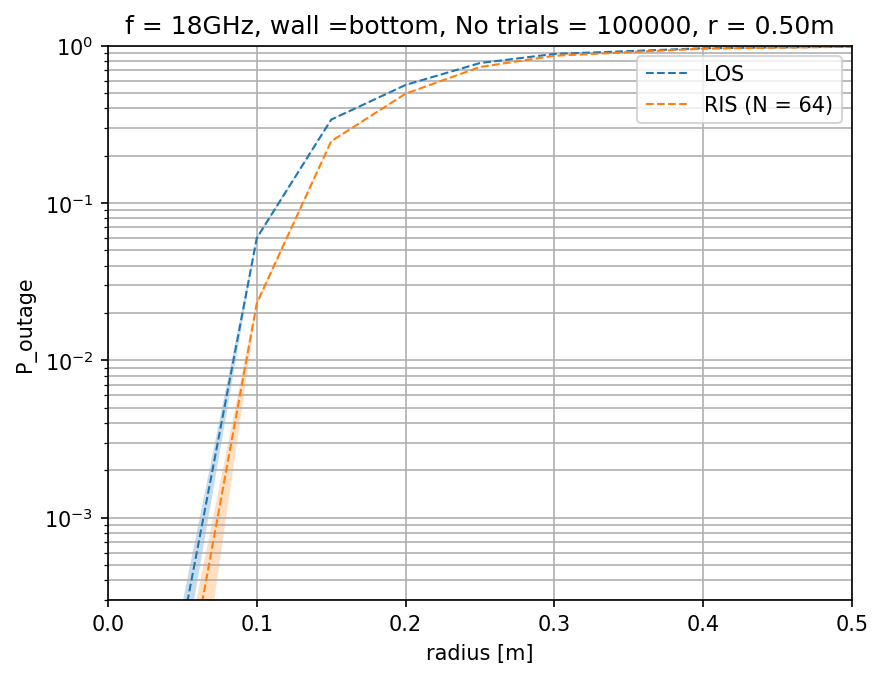

In [7]:
fig = plt.figure(dpi=150)
plt.plot(r_vec, Po_cn, '--', lw=1, label= 'LOS')
plt.fill_between(r_vec, Po_lw, Po_up, alpha=0.25)
plt.plot(r_vec, Pn_cn, '--', lw=1, label= 'RIS (N = %d)'%(N))
plt.fill_between(r_vec, Pn_lw, Pn_up, alpha=0.25)
    
    
plt.xlim(0, 0.5)
plt.ylim([0.0003, 1])
plt.grid(which='both')
plt.yscale('log')
plt.ylabel('P_outage')
plt.xlabel('radius [m]')
plt.title('f = %dGHz, wall =%s, No trials = %d, r = %.2fm'%(GHz, wall, trials, r))
plt.legend()
plt.show()  